In [1]:
# !pip install git+https://github.com/mrava87/pylops.git@feat-fourierradon

In [2]:
import numpy as np
import cupy as cp
import pylops
import matplotlib.pyplot as plt

from pylops.signalprocessing import FourierRadon2D, FourierRadon3D

cp.cuda.Device(device=1).use()

/home/ravasim/miniconda3_v23/envs/pylops_cupy_3090_working/lib/python3.9/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


<CUDA Device 1>

## 2D

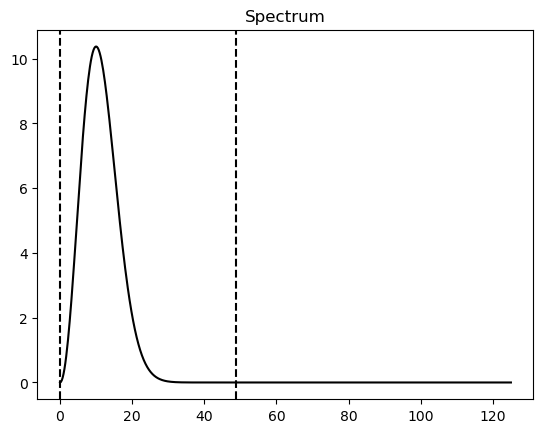

In [3]:
kind = "linear"
flims = [0, 200] # None

# Create axis (small centered)
par = {'ot': 0,    'dt': 0.004, 'nt': 1024,
       'ox': -500, 'dx': 5, 'nx': 201,
       'oy': -250, 'dy': 10, 'ny': 51,
       'f0': 10}
theta = [30, ]
t0 = [0.5, ]
amp = [1., ]

# Create axis
t, t2, x, _ = pylops.utils.seismicevents.makeaxis(par)
dt, dx = par['dt'], par['dx']

# Create wavelet
wav, _, wav_c = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])

# Generate model
if kind == "linear":
    v = 1500.
    pxx = np.sin(np.deg2rad(theta)) / v
    _, d = \
        pylops.utils.seismicevents.linear2d(x, t, v, t0, theta, amp, wav)
    npx, pxmax = par['nx'], 5e-4
    px = np.linspace(-pxmax, pxmax, npx)
    px_fou = px
else:
    pxx = 5e-7 * par['dx']
    _, d = \
        pylops.utils.seismicevents.parabolic2d(x, t, t0, 0, pxx / par['dx'], amp, wav)
    npx, pxmax = 2 * par['nx'], 2e-6
    px = np.linspace(-pxmax, pxmax, npx) * par['dx']
    px_fou = np.linspace(-pxmax, pxmax, npx)

nfft = int(2 ** np.ceil(np.log2(par['nt'])))
faxis = np.fft.rfftfreq(nfft, par["dt"])

plt.figure()
plt.plot(faxis, np.abs(np.fft.rfft(d[par['nx']//2], n=nfft)), 'k')
if flims is not None:
    plt.axvline(faxis[flims[0]], color='k', linestyle='--')
    plt.axvline(faxis[flims[1]], color='k', linestyle='--')
plt.title('Spectrum');

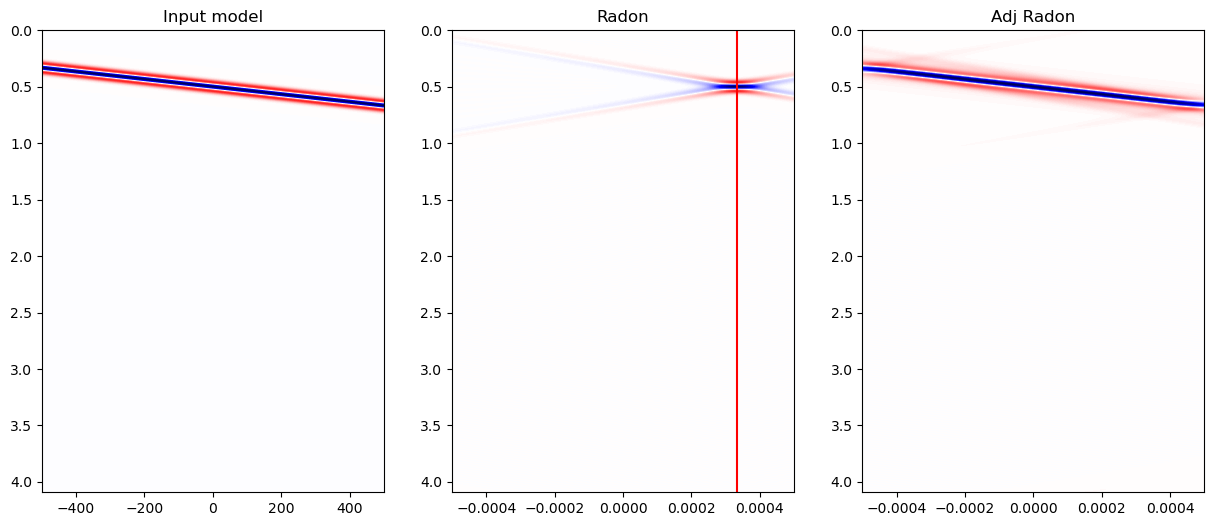

In [4]:
R2Opfourier = FourierRadon2D(t, x, px_fou, nfft, flims=flims, kind=kind, engine='numba', dtype='float64')
dL_four = R2Opfourier.H * d
dadj_four = R2Opfourier * dL_four

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_four.T, cmap='seismic_r', vmin=-dL_four.max(), vmax=dL_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pxx, color='r')
axs[1].set_title('Radon')
axs[1].axis('tight')
axs[2].imshow(dadj_four.T, cmap='seismic_r', vmin=-dadj_four.max(), vmax=dadj_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon')
axs[2].axis('tight');

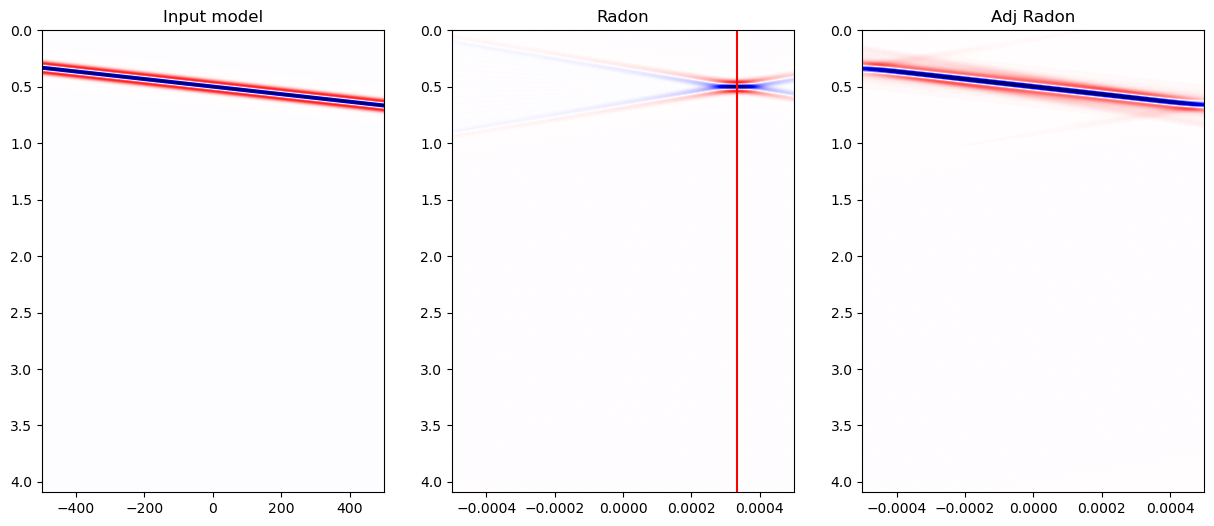

In [5]:
d_cp = cp.asarray(d)
R2Opfourier_cp = FourierRadon2D(t, cp.asarray(x), cp.asarray(px_fou), nfft, flims=flims, kind=kind, engine='numpy', dtype='float64')
R2Opfourier_cp.f = cp.asarray(R2Opfourier_cp.f)
dL_four_cp = R2Opfourier_cp.H * d_cp
dadj_four_cp = R2Opfourier_cp * dL_four_cp

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(dL_four_cp).T, cmap='seismic_r', vmin=-dL_four_cp.max(), vmax=dL_four_cp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pxx, color='r')
axs[1].set_title('Radon')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(dadj_four_cp).T, cmap='seismic_r', vmin=-dadj_four.max(), vmax=dadj_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon')
axs[2].axis('tight');

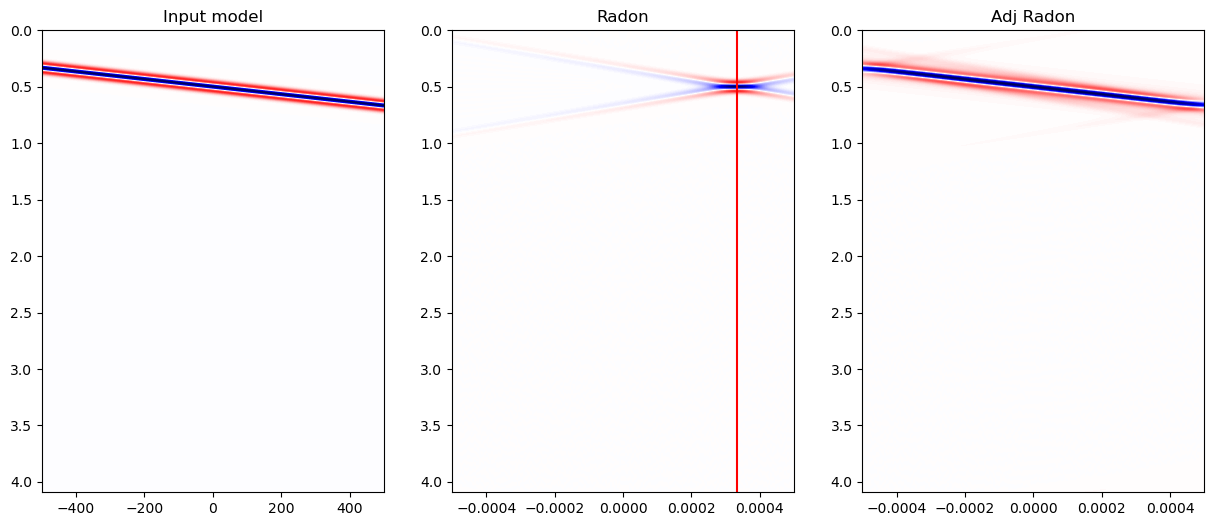

In [6]:
d_cp = cp.asarray(d)
R2Opfourier_cp = FourierRadon2D(t, cp.asarray(x), cp.asarray(px_fou), nfft, flims=flims, kind=kind, engine='cuda', num_threads_per_blocks=(16, 16), dtype='float64')
dL_four_cp = R2Opfourier_cp.H * d_cp
dadj_four_cp = R2Opfourier_cp * dL_four_cp

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(dL_four_cp).T, cmap='seismic_r', vmin=-dL_four_cp.max(), vmax=dL_four_cp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pxx, color='r')
axs[1].set_title('Radon')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(dadj_four_cp).T, cmap='seismic_r', vmin=-dadj_four.max(), vmax=dadj_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon')
axs[2].axis('tight');

In [7]:
%timeit -n 1 -r 2 R2Opfourier * dL_four
%timeit -n 1 -r 2 R2Opfourier.H * d

10.5 ms ± 612 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)
6.52 ms ± 937 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)


In [8]:
%timeit -n 4 -r 2 R2Opfourier_cp * dL_four_cp
%timeit -n 4 -r 2 R2Opfourier_cp.H * d_cp

2.54 ms ± 16.2 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)
2.48 ms ± 71.2 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


## 3D

Text(0.5, 1.0, 'Spectrum')

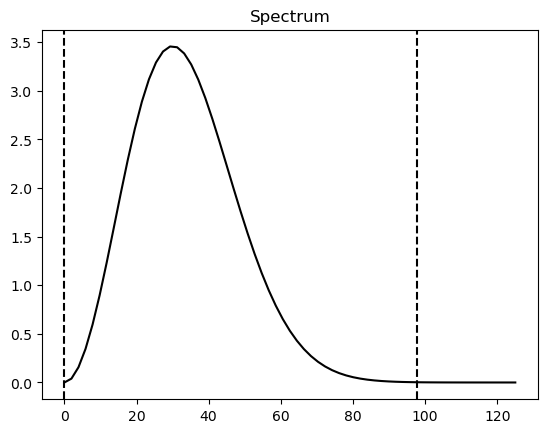

In [9]:
kind = "linear"
# flims = [0, 85] # None
# Create axis (small centered)
# par = {'ot': 0,    'dt': 0.004, 'nt': 256,
#        'ox': -200, 'dx': 20, 'nx': 21,
#        'oy': -200, 'dy': 10, 'ny': 41,
#        'f0': 30}

flims = [0, 50] # None
par = {'ot': 0,    'dt': 0.004, 'nt': 128,
       'ox': -100, 'dx': 20, 'nx': 11,
       'oy': -50, 'dy': 10, 'ny': 11,
       'f0': 30}
theta = [30, ]
phi = [10, ]
t0 = [0.1, ]
amp = [1., ]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)
dt, dx, dy = par['dt'], par['dx'], par['dy']

# Create wavelet
wav = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])[0]

# Generate model
if kind == "linear":
    v = 1500.
    pxx = np.sin(np.deg2rad(theta)) * np.cos(np.deg2rad(phi)) / v
    pyy = np.sin(np.deg2rad(theta)) * np.sin(np.deg2rad(phi)) / v
    _, d = \
    pylops.utils.seismicevents.linear3d(x, y, t, v, t0, theta, phi, amp, wav)

    npxy, pxymax = 2 * par['nx'], 5e-4
    px = np.linspace(-pxymax, pxymax, npxy)
    px_fou = px
    py = np.linspace(-pxymax, pxymax, npxy)
    py_fou = px
#else:
    # pxx = 5e-7 * par['dx']
    # pxx = 2e-7 * par['dx']
    # _, d = \
    #     pylops.utils.seismicevents.parabolic2d(x, t, t0, 0, pxx / par['dx'], pyy / par['dy'], amp, wav)
    # npxy, pxymax = par['nx'], 5e-4
    # px = np.linspace(-pxymax, pxymax, npxy) * par['dx']
    # py = np.linspace(-pxymax, pxymax, npxy) * par['dy']
    # px_fou = np.linspace(-pxymax, pxymax, npxy)
    # py_fou = np.linspace(-pxymax, pxymax, npxy)

nfft = int(2 ** np.ceil(np.log2(par['nt'])))
faxis = np.fft.rfftfreq(nfft, par["dt"])

plt.figure()
plt.plot(faxis, np.abs(np.fft.rfft(d[par['ny']//2, par['nx']//2], n=nfft)), 'k')
if flims is not None:
    plt.axvline(faxis[flims[0]], color='k', linestyle='--')
    plt.axvline(faxis[flims[1]], color='k', linestyle='--')
plt.title('Spectrum')

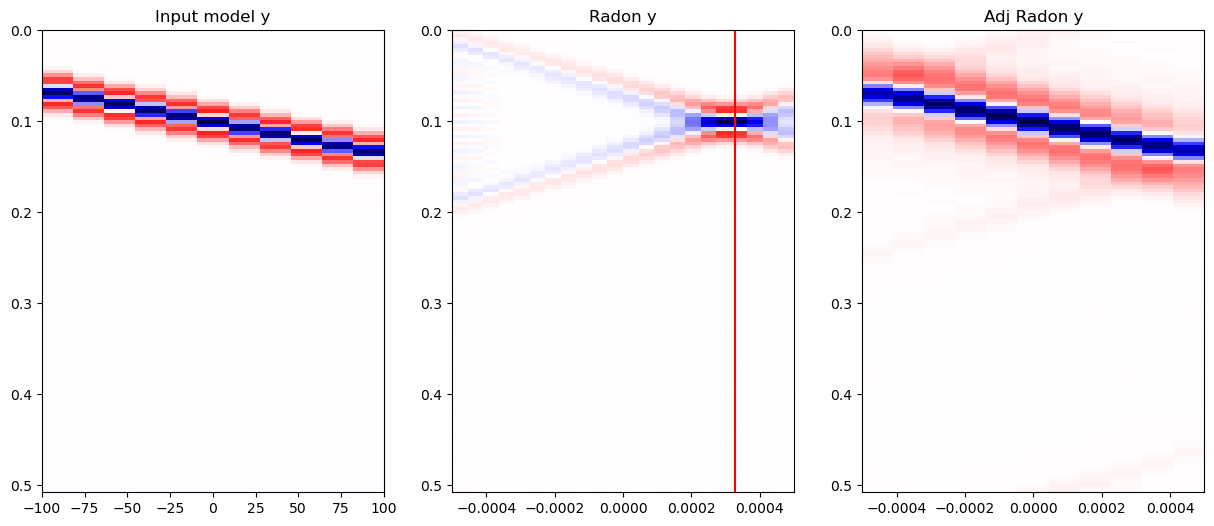

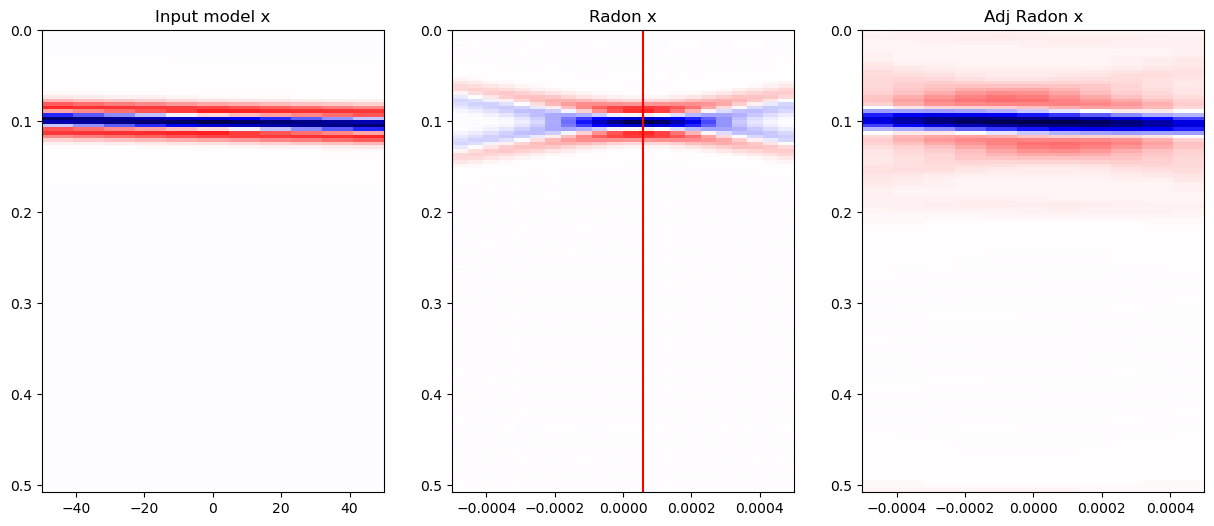

In [10]:
R3Opfourier = FourierRadon3D(t, y, x, py_fou, px_fou, nfft, flims=flims, kind=(kind, kind), engine='numpy', dtype='float64')
dL_four = R3Opfourier.H * d
dadj_four = R3Opfourier * dL_four

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model y')
axs[0].axis('tight')
axs[1].imshow(dL_four.reshape(npxy, npxy, par['nt'])[np.argmin(np.abs(pyy-py))].T,
              cmap='seismic_r', vmin=-dL_four.max(), vmax=dL_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pxx, color='r')
axs[1].set_title('Radon y')
axs[1].axis('tight')
axs[2].imshow(dadj_four.reshape(par['ny'], par['nx'], par['nt'])[par['ny']//2].T,
              cmap='seismic_r', vmin=-dadj_four.max(), vmax=dadj_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon y')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[:, par['nx']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(y[0], y[-1], t[-1], t[0]))
axs[0].set_title('Input model x')
axs[0].axis('tight')
axs[1].imshow(dL_four.reshape(npxy, npxy, par['nt'])[:, np.argmin(np.abs(pxx-px))].T,
              cmap='seismic_r', vmin=-dL_four.max(), vmax=dL_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pyy, color='r')
axs[1].set_title('Radon x')
axs[1].axis('tight')
axs[2].imshow(dadj_four.reshape(par['ny'], par['nx'], par['nt'])[:, par['nx']//2].T,
              cmap='seismic_r', vmin=-dadj_four.max(), vmax=dadj_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon x')
axs[2].axis('tight');

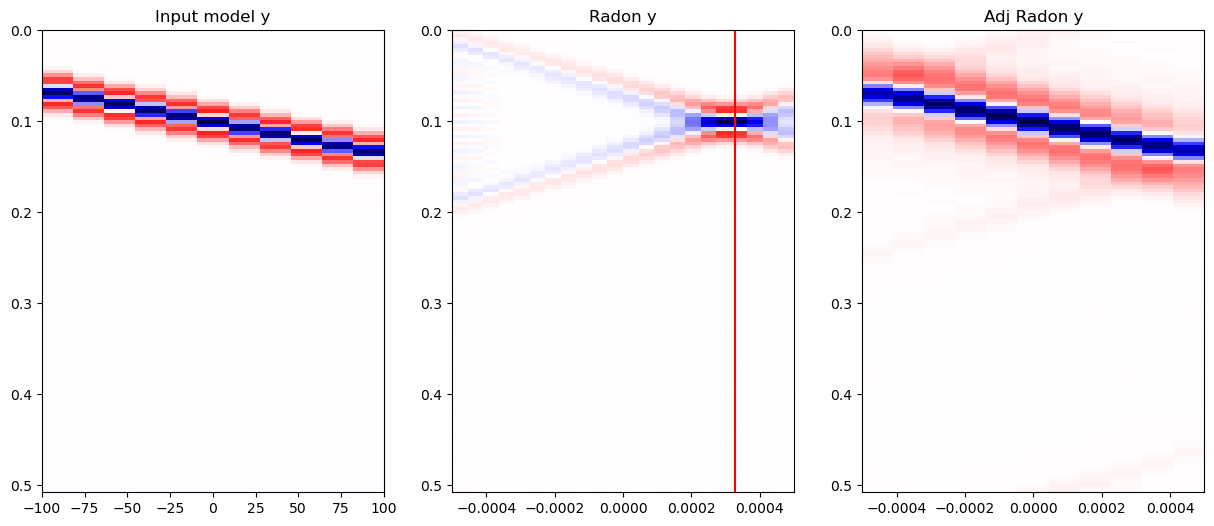

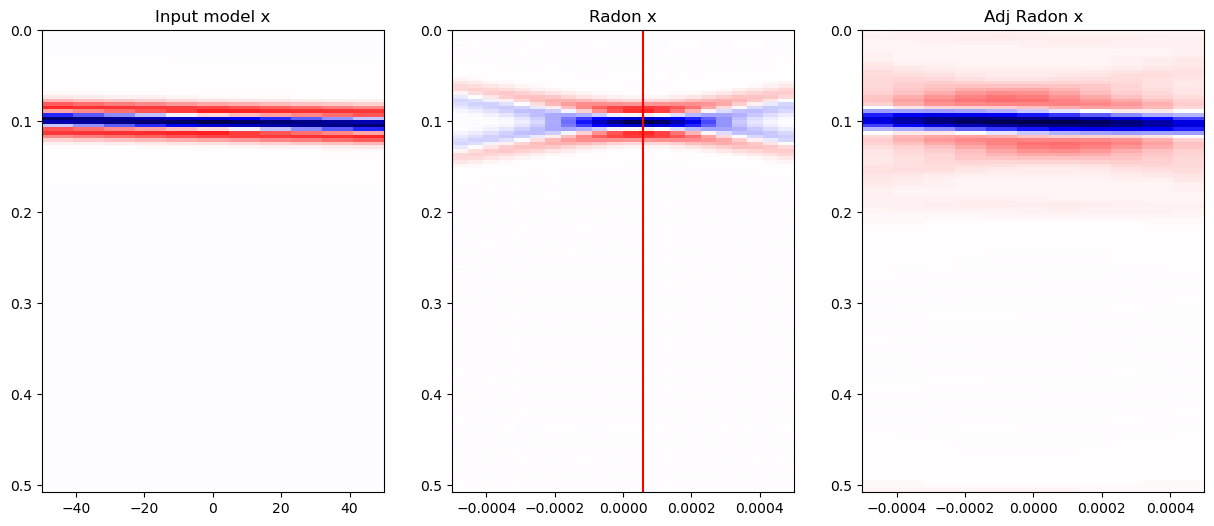

In [11]:
d_cp = cp.asarray(d)
R3Opfourier_cp = FourierRadon3D(t, cp.asarray(y), cp.asarray(x), cp.asarray(py_fou), cp.asarray(px_fou), nfft, flims=flims, kind=(kind, kind), engine='numpy', dtype='float64')
R3Opfourier_cp.f = cp.asarray(R3Opfourier_cp.f)
dL_four_cp = R3Opfourier_cp.H * d_cp
dadj_four_cp = R3Opfourier_cp * dL_four_cp

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model y')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(dL_four_cp).reshape(npxy, npxy, par['nt'])[np.argmin(np.abs(pyy-py))].T,
              cmap='seismic_r', vmin=-dL_four.max(), vmax=dL_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pxx, color='r')
axs[1].set_title('Radon y')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(dadj_four_cp).reshape(par['ny'], par['nx'], par['nt'])[par['ny']//2].T,
              cmap='seismic_r', vmin=-dadj_four.max(), vmax=dadj_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon y')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[:, par['nx']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(y[0], y[-1], t[-1], t[0]))
axs[0].set_title('Input model x')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(dL_four_cp).reshape(npxy, npxy, par['nt'])[:, np.argmin(np.abs(pxx-px))].T,
              cmap='seismic_r', vmin=-dL_four.max(), vmax=dL_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pyy, color='r')
axs[1].set_title('Radon x')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(dadj_four_cp).reshape(par['ny'], par['nx'], par['nt'])[:, par['nx']//2].T,
              cmap='seismic_r', vmin=-dadj_four.max(), vmax=dadj_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon x')
axs[2].axis('tight');

/home/ravasim/miniconda3_v23/envs/pylops_cupy_3090_working/lib/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


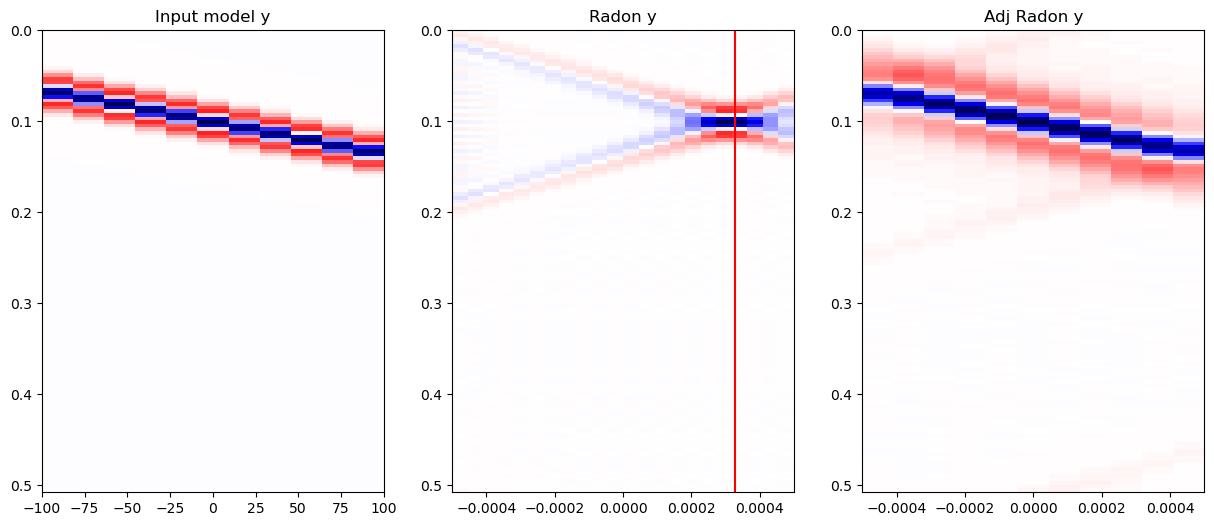

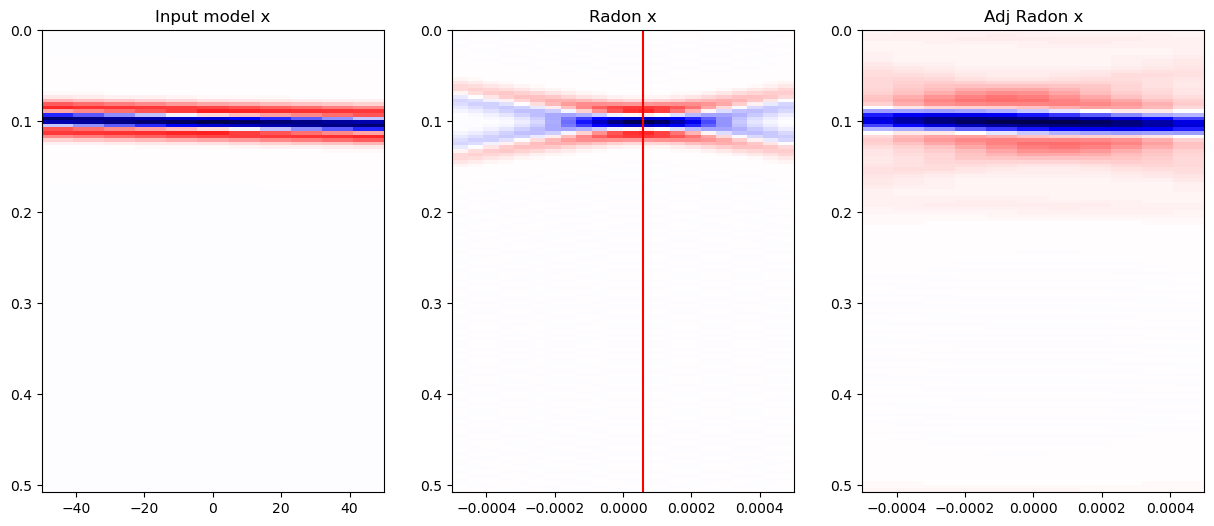

In [12]:
d_cp = cp.asarray(d)
R3Opfourier_cp = FourierRadon3D(t, cp.asarray(y), cp.asarray(x), cp.asarray(py_fou), cp.asarray(px_fou), nfft, flims=flims, kind=(kind, kind), engine='cuda', num_threads_per_blocks=(8, 8, 8), dtype='float64')
dL_four_cp = R3Opfourier_cp.H * d_cp
dadj_four_cp = R3Opfourier_cp * dL_four_cp

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model y')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(dL_four_cp).reshape(npxy, npxy, par['nt'])[np.argmin(np.abs(pyy-py))].T,
              cmap='seismic_r', vmin=-dL_four.max(), vmax=dL_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pxx, color='r')
axs[1].set_title('Radon y')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(dadj_four_cp).reshape(par['ny'], par['nx'], par['nt'])[par['ny']//2].T,
              cmap='seismic_r', vmin=-dadj_four.max(), vmax=dadj_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon y')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[:, par['nx']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(y[0], y[-1], t[-1], t[0]))
axs[0].set_title('Input model x')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(dL_four_cp).reshape(npxy, npxy, par['nt'])[:, np.argmin(np.abs(pxx-px))].T,
              cmap='seismic_r', vmin=-dL_four.max(), vmax=dL_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pyy, color='r')
axs[1].set_title('Radon x')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(dadj_four_cp).reshape(par['ny'], par['nx'], par['nt'])[:, par['nx']//2].T,
              cmap='seismic_r', vmin=-dadj_four.max(), vmax=dadj_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon x')
axs[2].axis('tight');

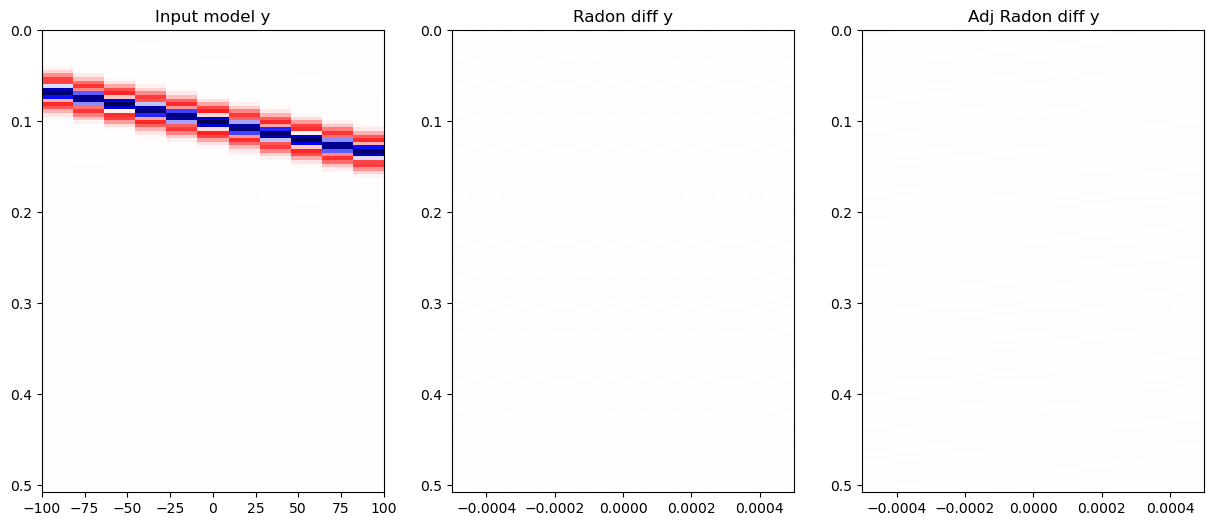

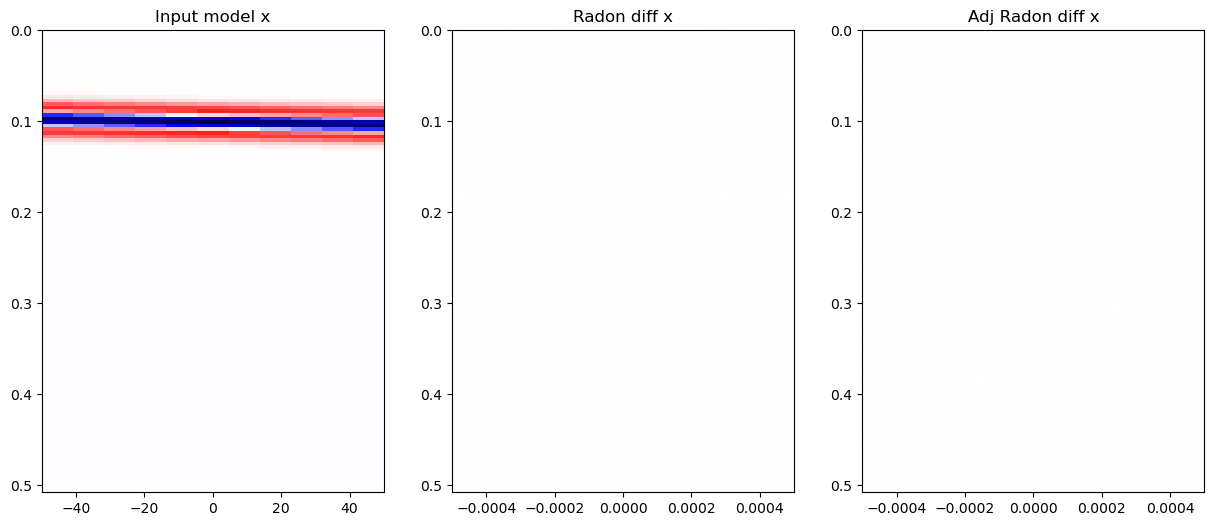

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model y')
axs[0].axis('tight')
axs[1].imshow((dL_four-cp.asnumpy(dL_four_cp)).reshape(npxy, npxy, par['nt'])[np.argmin(np.abs(pyy-py))].T,
              cmap='seismic_r', vmin=-dL_four.max(), vmax=dL_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon diff y')
axs[1].axis('tight')
axs[2].imshow((dadj_four-cp.asnumpy(dadj_four_cp)).reshape(par['ny'], par['nx'], par['nt'])[par['ny']//2].T,
              cmap='seismic_r', vmin=-dadj_four.max(), vmax=dadj_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon diff y')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[:, par['nx']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(y[0], y[-1], t[-1], t[0]))
axs[0].set_title('Input model x')
axs[0].axis('tight')
axs[1].imshow((dL_four-cp.asnumpy(dL_four_cp)).reshape(npxy, npxy, par['nt'])[:, np.argmin(np.abs(pxx-px))].T,
              cmap='seismic_r', vmin=-dL_four.max(), vmax=dL_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon diff x')
axs[1].axis('tight')
axs[2].imshow((dadj_four-cp.asnumpy(dadj_four_cp)).reshape(par['ny'], par['nx'], par['nt'])[:, par['nx']//2].T,
              cmap='seismic_r', vmin=-dadj_four.max(), vmax=dadj_four.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon diff x')
axs[2].axis('tight');

In [14]:
%timeit -n 2 -r 1 R3Opfourier * dL_four.ravel()
%timeit -n 2 -r 1 R3Opfourier.H * d.ravel()

243 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)
239 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)


In [15]:
%timeit -n 4 -r 2 R3Opfourier_cp * dL_four_cp.ravel()
%timeit -n 4 -r 2 R3Opfourier_cp.H * d_cp.ravel()

3.1 ms ± 431 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)
1.65 ms ± 56 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)
